### Let's start with downloading the raw data

In [1]:
import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader_functions.download_data import download_raw_data
current_dir = os.getcwd()

In [2]:
### TODO update this section per dataset
dataset_config = {
    'dataset_name': 'airbnb_price',
    'source': 'kaggle', # ['kaggle', 'local', 'openml', 'hf']
    'remote_path': 'airbnb/seattle',
    'files': ['listings.csv'],
    'rename_files': ['airbnb_data.csv'],
    'task': 'reg', # ['reg', 'clf']
    'target': 'price',
}

In [3]:
if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

if download_raw_data(
    dataset_config=dataset_config,
    download_path=download_path,
    force_download=False,
    remove_unlisted=True,
) is not None:
    print(f"Downloaded {dataset_config['dataset_name']} dataset to {download_path}")

Info: Dataset already downloaded in /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/airbnb_price.
Downloaded airbnb_price dataset to /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/airbnb_price


### Now we need to preprocess the data

In [4]:
from dataloader_functions.load_and_pp_raw_data import _drop_empty_columns, _drop_single_value_columns
from dataloader_functions.utils.data_2_df import read_any_to_df
import pandas as pd

import os
current_dir = os.getcwd()

In [5]:
dataset_files_df = []

if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for file in dataset_config['rename_files']:

    file_location = os.path.join(download_path, file)

    print(f"Loading {file_location}")

    dataset_files_df.append(read_any_to_df(file_location))

# example of the loaded df data:
pd.set_option('display.max_columns', None)
dataset_files_df[0].head(n=3)

Loading /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/airbnb_price/airbnb_data.csv


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [6]:
## Run some basic data cleaning

dataset_files_gen_cleaned = []
missing_ratio_threshold = 0.5 # TODO the threshold can be changed

for df_file in dataset_files_df:
    df_size = df_file.shape
    # 1. Drop columns with more than 50% missing values
    df_file = _drop_empty_columns(df_file, threshold=missing_ratio_threshold)   
    # 2. Drop columns with only one unique value
    df_file = _drop_single_value_columns(df_file)
    # 3. remove duplicates
    df_file = df_file.drop_duplicates()
    # 4. remove rows with missing target values
    df_file = df_file[df_file[dataset_config['target']].notna()]
    # 5. drop unnamed columns
    df_file = df_file.loc[:, ~df_file.columns.str.contains('^Unnamed')]

    dataset_files_gen_cleaned.append(df_file)

    print(f"Dataframe shape before/afrer cleaning: {df_size} / {df_file.shape}")

Dropped: Index(['square_feet', 'monthly_price', 'security_deposit', 'license'], dtype='object')
Dataframe shape before/afrer cleaning: (3818, 92) / (3818, 78)


In [7]:
## TODO: Now run custom data cleaning -> remove non-essential columns

cols_to_drop = ['id', 'listing_url', 'thumbnail_url', 'host_url', 'medium_url',
                'picture_url', 'xl_picture_url', 'host_id', 'host_thumbnail_url', 'host_picture_url', # so far removing bad features
                'name', 'host_name', 'host_location', 'street', 'host_neighbourhood', 'host_listings_count', # removing duplicate features
                'host_total_listings_count', 'weekly_price', 'cleaning_fee', # removing potential leakage
                'maximum_nights', 'first_review', 'last_review' # removing weak features
                ]

dataset_files_cleaned = []

# assuming for multiple files we still want to drop the same columns
for df_file in dataset_files_gen_cleaned:
    df_size = df_file.shape
    for col in cols_to_drop:
        if col in df_file.columns:
            df_file.drop(col, axis=1, inplace=True)
        else:
            print(f"Column {col} not found in dataframe")

    dataset_files_cleaned.append(df_file)    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df_file.shape}")

dataset_files_cleaned[0].head(n=3)

Dataframe shape before/afrer by-hand cleaning: (3818, 78) / (3818, 56)


,summary,space,description,neighborhood_overview,notes,transit,host_since,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,smart_location,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,2011-08-11,"I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,"Seattle, WA",47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$85.00,2,$5.00,1,4 weeks ago,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",2013-02-21,Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,"Seattle, WA",47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",$150.00,1,$0.00,2,today,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48
2,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,2014-06-12,i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,f,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,"Seattle, WA",47.629724,-122.369483,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$975.00,10,$25.00,4,5 weeks ago,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15


In [8]:
# TODO: some custom data cleaning

import copy 
import pandas as pd

tmp_df = copy.deepcopy(dataset_files_cleaned)
dataset_files_by_hand_cleaned = []

for df_file in dataset_files_cleaned:
    print(f"Dataframe shape before custom cleaning: {df_file.shape}")

    # 1. Convert 'host_since' to timestamp seconds
    if 'host_since' in df_file.columns:
        df_file['host_since'] = pd.to_datetime(df_file['host_since'], format='%Y-%m-%d', errors='coerce')
        df_file['host_since'] = df_file['host_since'].astype('int64') / 1e9  # nanoseconds to seconds

    print(f"Dataframe shape after custom cleaning: {df_file.shape}")

    dataset_files_by_hand_cleaned.append(df_file)

# Reset the dataframe list to the version before custom cleaning -> next cells work with dataset_files_by_hand_cleaned
dataset_files_cleaned = tmp_df


Dataframe shape before custom cleaning: (3818, 56)
Dataframe shape after custom cleaning: (3818, 56)


### Now it is time to visualize our changes

In [9]:
pd.set_option('display.max_columns', None)

dataset_files_by_hand_cleaned[0].head(n=3)

,summary,space,description,neighborhood_overview,notes,transit,host_since,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,smart_location,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,1.313021e+09,"I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,"Seattle, WA",47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$85.00,2,$5.00,1,4 weeks ago,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",1.361405e+09,Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,"Seattle, WA",47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",$150.00,1,$0.00,2,today,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48
2,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,1.402531e+09,i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,f,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,"Seattle, WA",47.629724,-122.369483,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$975.00,10,$25.00,4,5 weeks ago,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15


Let's figure out which columns should be viewed as categorical / numerical / textual

we can start with a simple heuristic:
1. numerical is everything which
    - keeps most of its character length after non-numeral strip
    - has about the same number of unique values after the strip
    + for the purpose of keeping "semantic information", hand picked columns can be viewed also as non-numerical, that is not the default benchmark approach though

2. categorical is everthing non numerical, which can be then divided into N (where N << Num instances) unique categories

3. textual is everything else

In [10]:
import pandas as pd
import re

def is_mostly_numeric(series, length_threshold=0.5, unique_threshold=0.8):
    """Check if column is mostly numeric after stripping non-numeric chars."""
    stripped = series.astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    
    original_len = series.astype(str).str.len().replace(0, 1)  # avoid div by zero
    length_ratio = (stripped.str.len() / original_len).mean()

    unique_ratio = stripped.nunique(dropna=False) / max(series.nunique(dropna=False), 1)

    return length_ratio > length_threshold and unique_ratio > unique_threshold

def classify_columns(df, unique_ratio_threshold=None, explicit_nunique_threshold=None):
    """
    Classify dataframe columns into numerical, categorical, textual.
    - Binary categorical (2 unique values) is considered categorical.
    """
    n_rows = len(df)

    # Determine threshold for categorical vs textual
    if explicit_nunique_threshold is not None:
        nunique_threshold = explicit_nunique_threshold
    elif unique_ratio_threshold is not None:
        nunique_threshold = int(unique_ratio_threshold * n_rows)
    else:
        nunique_threshold = int(0.05 * n_rows)  # default 5%

    nunique_threshold = max(10, nunique_threshold)  # safeguard
    print(f"Threshold for categorical vs textual: {nunique_threshold}")

    numerical_cols = []
    categorical_cols = []
    textual_cols = []

    for col in df.columns:
        series = df[col]
        nunique = series.nunique(dropna=False)

        if pd.api.types.is_numeric_dtype(series):
            if nunique <= nunique_threshold:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        
        elif pd.api.types.is_string_dtype(series) or pd.api.types.is_object_dtype(series):
            if is_mostly_numeric(series):
                numerical_cols.append(col)
            else:
                if nunique <= nunique_threshold:
                    categorical_cols.append(col)
                else:
                    textual_cols.append(col)
        else:
            print(f"⚠️ Unhandled column type: '{col}' (dtype={series.dtype})")

    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Textual columns ({len(textual_cols)}): {textual_cols}")

    return numerical_cols, categorical_cols, textual_cols

# Example usage:
for df_file in dataset_files_by_hand_cleaned:
    # Ratio-based (5% of rows)
    # umerical_cols, categorical_cols, textual_cols = classify_columns(df_file, unique_ratio_threshold=0.05)
    print("")
    # OR explicit value (e.g., anything <= 50 is categorical)
    numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, explicit_nunique_threshold=50)



Threshold for categorical vs textual: 50
Numerical columns (13): ['host_since', 'host_response_rate', 'host_acceptance_rate', 'zipcode', 'latitude', 'longitude', 'price', 'extra_people', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'reviews_per_month']
Categorical columns (32): ['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'city', 'state', 'smart_location', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'guests_included', 'minimum_nights', 'calendar_updated', 'availability_30', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count']
Textual

Now let's just try to visualize the kept features, their example values, and their cat/num/text allocation

In [11]:
summary = []
for col in df_file.columns:
    if col in categorical_cols:
        col_type = "categorical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in textual_cols:
        col_type = "textual"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in numerical_cols:
        col_type = "numerical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = '~ ' + str(num_categories) + ' ~'
    else:
        col_type = "unknown"
        num_categories_display = '--'

    example = df_file[col].dropna().iloc[0] if df_file[col].dropna().size > 0 else None
    summary.append({
        'Column Name': col,
        'Example Value': str(example),
        'Type': col_type,
        '# Categories': num_categories_display
    })

summary_df = pd.DataFrame(summary)

# TODO: by hand changes of the type and category count -> e.g. for 'Location':
# 'weekly_price' -> numerical
summary_df.loc[summary_df['Column Name'] == 'weekly_price', 'Type'] = 'numerical'

pd.set_option('display.max_rows', None)
display(summary_df)  # Or print(summary_df)


,Column Name,Example Value,Type,# Categories
0,summary,Chemically sensitive? We've removed the irrita...,textual,3478
1,space,Make your self at home in this charming one-be...,textual,3119
2,description,Make your self at home in this charming one-be...,textual,3742
3,neighborhood_overview,"Queen Anne is a wonderful, truly functional vi...",textual,2506
4,notes,What's up with the free pillows? Our home was...,textual,1999
5,transit,"Convenient bus stops are just down the block, ...",textual,2574
6,host_since,1313020800.0,numerical,~ 1381 ~
7,host_about,"I am an artist, interior designer, and run a s...",textual,2011
8,host_response_time,within a few hours,categorical,4
9,host_response_rate,96%,numerical,~ 45 ~


#### We also need to make sure that numerical columns are actually numerical :)

In [12]:
import re
import pandas as pd
import copy

from dataloader_functions.load_and_pp_raw_data import clean_numerical_columns

summary_df, dataset_files_by_hand_cleaned = clean_numerical_columns(summary_df, dataset_files_by_hand_cleaned)

pd.set_option('display.max_rows', None)
display(summary_df)


Column 'host_response_rate' requires cleaning (non-numeric artifacts found).
Column 'host_acceptance_rate' requires cleaning (non-numeric artifacts found).
Column 'zipcode' requires cleaning (non-numeric artifacts found).
Column 'price' requires cleaning (non-numeric artifacts found).
Column 'extra_people' requires cleaning (non-numeric artifacts found).


,Column Name,Example Value,Type,# Categories
0,summary,Chemically sensitive? We've removed the irrita...,textual,3478
1,space,Make your self at home in this charming one-be...,textual,3119
2,description,Make your self at home in this charming one-be...,textual,3742
3,neighborhood_overview,"Queen Anne is a wonderful, truly functional vi...",textual,2506
4,notes,What's up with the free pillows? Our home was...,textual,1999
5,transit,"Convenient bus stops are just down the block, ...",textual,2574
6,host_since,1313020800.0,numerical,1381
7,host_about,"I am an artist, interior designer, and run a s...",textual,2011
8,host_response_time,within a few hours,categorical,4
9,host_response_rate,96.0,numerical,45


### Saving the processed data and loading it back up

In [13]:
import os
import pandas as pd

# Handle rename_files fallback
if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for i, df_file in enumerate(dataset_files_by_hand_cleaned):
    df_with_meta = df_file.copy()

    # Get corresponding file name
    file_name = dataset_config['rename_files'][i]
    file_base = os.path.splitext(file_name)[0]

    # Try assigning multi-index header from summary
    try:
        df_with_meta.columns = pd.MultiIndex.from_frame(
            summary_df[['Column Name', 'Type', '# Categories']]
        )
        local_summary = summary_df.copy()
    except ValueError:
        local_summary = summary_df.copy()
        if dataset_config['target'] in local_summary['Column Name'].values:
            local_summary = local_summary[local_summary['Column Name'] != dataset_config['target']]
            df_with_meta.columns = pd.MultiIndex.from_frame(
                local_summary[['Column Name', 'Type', '# Categories']]
            )
        else:
            raise

    # Construct and save everything together
    output_filename = f"{file_base}_processed.pkl"
    output_path = os.path.join(download_path, output_filename)

    save_bundle = {
        'data': df_with_meta,
        'summary': local_summary,
        'config': dataset_config
    }

    pd.to_pickle(save_bundle, output_path)
    print(f"Saved: {output_path}")


Saved: /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/airbnb_price/airbnb_data_processed.pkl


In [14]:
import os
import pandas as pd

# Loop through processed files in rename_files
for file_name in dataset_config['rename_files']:
    # Remove .csv or .tsv extension to get the base name
    file_base = os.path.splitext(file_name)[0]
    processed_filename = f"{file_base}_processed.pkl"
    processed_path = os.path.join(download_path, processed_filename)

    # Load the bundled dictionary (data + summary + config)
    bundle = pd.read_pickle(processed_path)

    # Extract components
    loaded_df = bundle['data']
    summary_df = bundle['summary']
    loaded_config = bundle['config']

    print(f"\n=== {file_base.upper()} ===")
    print(f"Loaded config keys: {list(loaded_config.keys())}")

    # Show metadata
    meta_df = pd.DataFrame(loaded_df.columns.tolist(), columns=['Column Name', 'Type', '# Categories'])
    display(meta_df)

    # Flatten for modeling
    loaded_df.columns = loaded_df.columns.get_level_values(0)
    
    display(loaded_df.head(n=3))



=== AIRBNB_DATA ===
Loaded config keys: ['dataset_name', 'source', 'remote_path', 'files', 'rename_files', 'task', 'target']


,Column Name,Type,# Categories
0,summary,textual,3478
1,space,textual,3119
2,description,textual,3742
3,neighborhood_overview,textual,2506
4,notes,textual,1999
5,transit,textual,2574
6,host_since,numerical,1381
7,host_about,textual,2011
8,host_response_time,categorical,4
9,host_response_rate,numerical,45


Column Name,summary,space,description,neighborhood_overview,notes,transit,host_since,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,smart_location,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,1.313021e+09,"I am an artist, interior designer, and run a s...",within a few hours,96.0,100.0,f,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119.0,"Seattle, WA",47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,2,5.0,1,4 weeks ago,14,41.0,71.0,346.0,207.0,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",1.361405e+09,Living east coast/left coast/overseas. Time i...,within an hour,98.0,100.0,t,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119.0,"Seattle, WA",47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,1,0.0,2,today,13,13.0,16.0,291.0,43.0,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48
2,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,1.402531e+09,i love living in Seattle. i grew up in the mi...,within a few hours,67.0,100.0,f,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119.0,"Seattle, WA",47.629724,-122.369483,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0,10,25.0,4,5 weeks ago,1,6.0,17.0,220.0,20.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15


### Bonus insights (Regression)

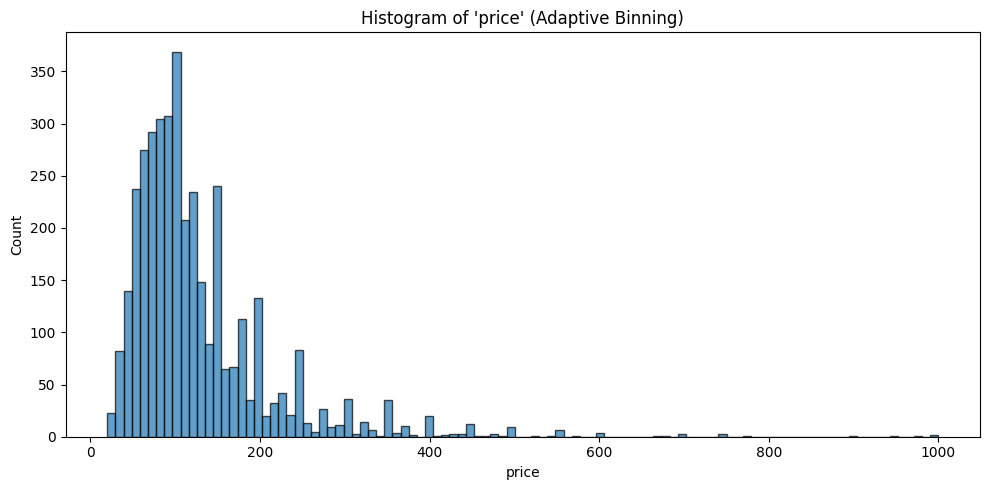

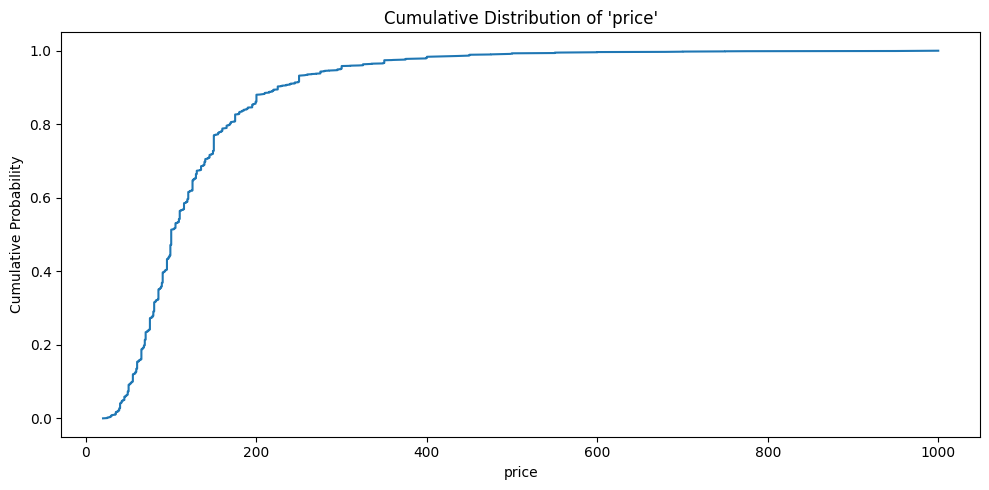

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get target series
target_series = loaded_df[dataset_config['target']]

# 1️⃣ Histogram with Freedman-Diaconis rule for binning
q25, q75 = np.percentile(target_series, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr * len(target_series) ** (-1/3)
bin_count = int((target_series.max() - target_series.min()) / bin_width)
bin_count = max(10, bin_count)  # Ensure reasonable minimum bin count

plt.figure(figsize=(10, 5))
plt.hist(target_series, bins=bin_count, edgecolor='black', alpha=0.7)
plt.title(f"Histogram of '{dataset_config['target']}' (Adaptive Binning)")
plt.xlabel(dataset_config['target'])
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2️⃣ Cumulative Distribution Function (CDF)
target_sorted = target_series.sort_values()
cdf = np.arange(len(target_sorted)) / len(target_sorted)

plt.figure(figsize=(10, 5))
plt.plot(target_sorted, cdf, color='tab:blue')
plt.title(f"Cumulative Distribution of '{dataset_config['target']}'")
plt.xlabel(dataset_config['target'])
plt.ylabel('Cumulative Probability')
plt.tight_layout()
plt.show()



In [16]:
from baseline_eval import evaluate_baseline, plot_model_performance_summary
results = evaluate_baseline(
    df=loaded_df,
    model='AGTabular',
    df_name=dataset_config['dataset_name'],
    label_col= dataset_config['target'],
    task_type=dataset_config['task'],
    textual_cols=textual_cols,
    k_folds=5,
    seed=0,
    max_samples=3000,
    output_path=f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250521_134350"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #53~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Jan 15 19:18:46 UTC 2
CPU Count:          64
Memory Avail:       477.32 GB / 503.54 GB (94.8%)
Disk Space Avail:   33802.83 GB / 51214.59 GB (66.0%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1



[WRAPPER] Running stratified downsampling mode for task: reg
Info: 
[INFO] Downsampling dataframe: airbnb_price (original rows: 3818)
Downsampled 3000 rows for airbnb_price dataset.


Beginning AutoGluon training ... Time limit = 360s
AutoGluon will save models to "/home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/AutogluonModels/ag-20250521_134350"
Train Data Rows:    2400
Train Data Columns: 55
Label Column:       price
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    488705.35 MB
	Train Data (Original)  Memory Usage: 11.06 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 6 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeF

In [17]:
import pandas as pd
from baseline_eval import evaluate_baseline, plot_model_performance_summary
rs = pd.read_csv(f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv")
plot_model_performance_summary(name=dataset_config['dataset_name'],task=dataset_config['task'], df=rs)

Saving plot to ../../baseline_results/plots/reg/score
Saving plot to ../../baseline_results/plots/reg/loss
Saving plot to ../../baseline_results/plots/reg/roc_auc


{'score':                                     mean       std
 model                                             
 AutoGluon_Tabular_with_text     0.638018  0.023635
 AutoGluon_Tabular_without_text  0.644874  0.039090,
 'loss':                                      mean       std
 model                                              
 AutoGluon_Tabular_without_text  54.293960  4.187400
 AutoGluon_Tabular_with_text     54.902896  4.313399,
 'roc_auc':                                 mean  std
 model                                    
 AutoGluon_Tabular_with_text      NaN  NaN
 AutoGluon_Tabular_without_text   NaN  NaN}

In [18]:
rs = pd.read_csv(f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv")
plot_model_performance_summary(name=dataset_config['dataset_name'],task=dataset_config['task'], df=rs)

Saving plot to ../../baseline_results/plots/reg/score
Saving plot to ../../baseline_results/plots/reg/loss
Saving plot to ../../baseline_results/plots/reg/roc_auc


{'score':                                     mean       std
 model                                             
 AutoGluon_Tabular_with_text     0.638018  0.023635
 AutoGluon_Tabular_without_text  0.644874  0.039090,
 'loss':                                      mean       std
 model                                              
 AutoGluon_Tabular_without_text  54.293960  4.187400
 AutoGluon_Tabular_with_text     54.902896  4.313399,
 'roc_auc':                                 mean  std
 model                                    
 AutoGluon_Tabular_with_text      NaN  NaN
 AutoGluon_Tabular_without_text   NaN  NaN}